In [1]:
import boto3
import pandas as pd
from io import StringIO

# Define S3 dataset path
bucket_name = "mydataset-710"
file_key = "resampled_data.csv"

# Initialize S3 client
s3_client = boto3.client("s3")

# Load dataset from S3
obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
df = pd.read_csv(obj["Body"])

print("Dataset loaded successfully from S3!")
print(df.head())

Dataset loaded successfully from S3!
   step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
0     1     3   9839.64    757869       170136.0       160296.36   1662094   
1     1     3   1864.28   2188998        21249.0        19384.72   1733924   
2     1     4    181.00   1002156          181.0            0.00    439685   
3     1     1    181.00   5828262          181.0            0.00    391696   
4     1     3  11668.14   3445981        41554.0        29885.86    828919   

   oldbalanceDest  newbalanceDest  isFlaggedFraud  isFraud  
0             0.0             0.0               0        0  
1             0.0             0.0               0        0  
2             0.0             0.0               0        1  
3         21182.0             0.0               0        1  
4             0.0             0.0               0        0  


In [2]:
from sklearn.model_selection import train_test_split

# Assuming the last column is the target variable
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]   

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Store model scores
model_scores = {}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]  

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probs)
    
    model_scores[name] = {"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc, "model": model, "y_probs": y_probs, "y_pred": y_pred}

    print(f"{name}: Accuracy={accuracy:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}")

Training Random Forest...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Random Forest: Accuracy=0.9996, F1=0.9996, ROC-AUC=1.0000
Training Logistic Regression...
Logistic Regression: Accuracy=0.9486, F1=0.9487, ROC-AUC=0.9884
Training Decision Tree...
Decision Tree: Accuracy=0.9995, F1=0.9995, ROC-AUC=0.9995
Training XGBoost...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:20:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: Accuracy=0.9985, F1=0.9985, ROC-AUC=1.0000


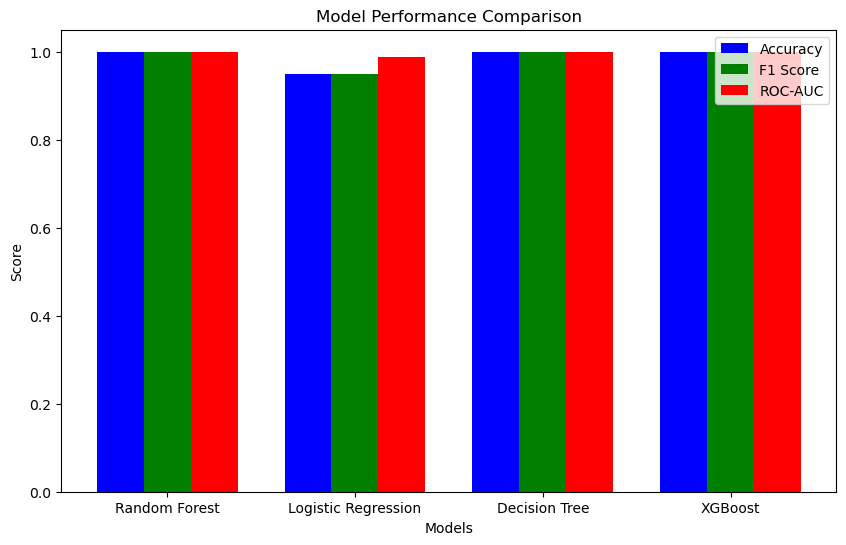

In [7]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(model_scores.keys())
accuracy_values = [model_scores[m]["accuracy"] for m in model_names]
f1_values = [model_scores[m]["f1"] for m in model_names]
roc_auc_values = [model_scores[m]["roc_auc"] for m in model_names]

plt.figure(figsize=(10, 6))
x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, accuracy_values, width=width, label='Accuracy', color='blue')
plt.bar(x, f1_values, width=width, label='F1 Score', color='green')
plt.bar(x + width, roc_auc_values, width=width, label='ROC-AUC', color='red')

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(x, model_names)
plt.legend()
plt.show()

In [8]:
import joblib

# Find the best model based on ROC-AUC score
best_model_name = max(model_scores, key=lambda x: model_scores[x]["roc_auc"])
best_model = model_scores[best_model_name]["model"]

print(f"Best Model: {best_model_name}")

# Save locally in SageMaker instance
model_filename = f"/tmp/{best_model_name.replace(' ', '_')}.pkl"
joblib.dump(best_model, model_filename)

# Define S3 path for model storage
s3_model_path = f"s3://{bucket_name}/models/{best_model_name}.pkl"

# Upload to S3
s3_client.upload_file(model_filename, bucket_name, f"models/{best_model_name}.pkl")

print(f"Best model saved to S3: {s3_model_path}")

Best Model: Random Forest
Best model saved to S3: s3://mydataset-710/models/Random Forest.pkl
